# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')



In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

import sys
sys.path.append("../models/")

import models.dcgan as dcgan
import models.mlp as mlp
import models.dcgan_orig as do

# Set up data sources

In [2]:
dataroot = "/home/adalbert/data/world-cities/"

#### Training data is in ./train (all cities > 10k population)

In [3]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])

len(files_df)

24986

#### Add in region information

In [16]:
regions_df = pd.read_csv("/home/adalbert/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}

files_df['region'] = files_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)


#### Preprocessing: assign class of "built area"
- by deciles

In [17]:
from skimage.io import imread

def compute_built_area(f):
    img = imread(f)
    img[img==128] = 0
    return (img > 0).sum() / float(img.shape[0]*img.shape[1])

files_df['built pct'] = files_df['filename'].apply(compute_built_area)

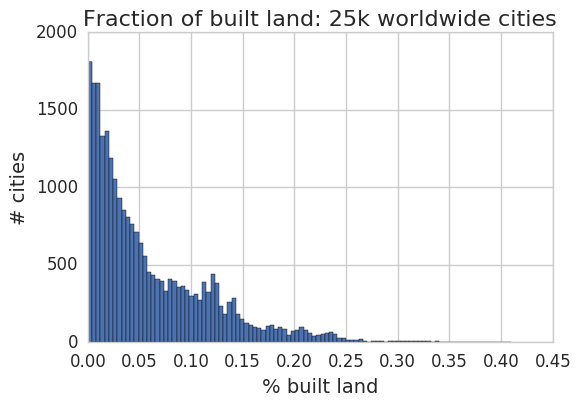

In [18]:
files_df['built pct'].hist(bins=100, figsize=(6,4))
sns.set_style("whitegrid", {'axes.grid' : False})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

In [19]:
q = files_df['built pct'].quantile(np.linspace(0.1,1,10))
files_df['decile'] = files_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )

#### Split into training and validation

In [20]:
idx = np.random.choice(range(len(files_df)), int(len(files_df)*0.95), \
                       replace=False)
train_df = files_df.iloc[idx]
valid_df  = files_df.iloc[list(set(range(len(files_df))) - set(idx))]

# train_df.to_csv(dataroot + "/train.csv")
# valid_df.to_csv(dataroot + "/valid.csv")

len(train_df), len(valid_df)

(23736, 1250)

#### Test data is under ./test/ and contains more carefully-filtered samples

In [21]:
import glob

files = glob.glob(dataroot + "/test/*/*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

len(test_df)

3012

In [22]:
test_df['built pct'] = test_df['filename'].apply(compute_built_area)
test_df['decile'] = test_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )
test_df['region'] = test_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)

# test_df.to_csv(dataroot + "/test.csv")


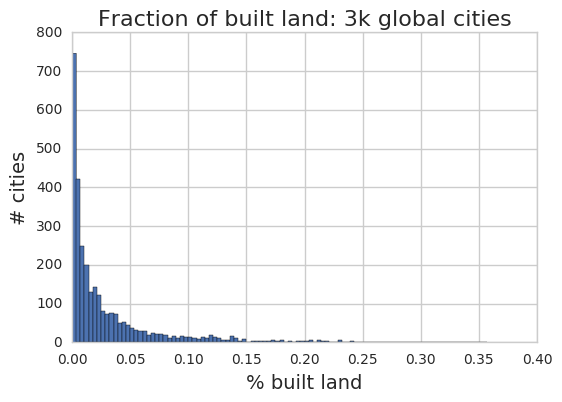

In [23]:
test_df['built pct'].hist(bins=100, figsize=(6,4))
plt.title("Fraction of built land: 3k global cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

# Train GAN
We could spawn external process, but better just copy the command into an external script and run in a separate terminal. 

In [24]:
train_df.head()

,filename,class,country,population,built pct,decile,region
23638,/home/adalbert/data/world-cities//train/small/...,small,my,52746,0.040263,5,Asia
20487,/home/adalbert/data/world-cities//train/very-s...,very-small,in,18326,0.020891,3,Asia
20638,/home/adalbert/data/world-cities//train/very-s...,very-small,it,22105,0.047971,5,Europe
20815,/home/adalbert/data/world-cities//train/very-s...,very-small,us,20823,0.025012,3,Americas
4671,/home/adalbert/data/world-cities//train/very-s...,very-small,fr,38098,0.125314,8,Europe


#### Set up batching

In [ ]:
import sys
sys.path.append("/home/adalbert/nbserver/urbanization-patterns/models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, default_loader

In [ ]:
val_nodata = 128

pimg = grayscale_loader(test_df['filename'].iloc[0])

plt.imshow(pimg)

In [ ]:
sys.path.append("./pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader
dataset = ImageDataFrame(df=train_df, classCol=opt.classCol,
                         loader=grayscale_loader,
                         transform=transforms.Compose([
                               transforms.RandomHorizontalFlip(),
                               transforms.Scale(opt.imageSize),
                               transforms.CenterCrop(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

#### Set up models

In [26]:
ngpu = 4
nz = 100
ngf = 64
ndf = 64
nc = 1
n_extra_layers = 0

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# initialize generator
netG = do._netG(ngpu, nc, nz, ngf)
netG.apply(weights_init)
print(netG)

# initialize discriminator
netD = do._netD(ngpu, nc, ndf)
netD.apply(weights_init)
print(netD)


_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)
_netD (
  (main): Sequential (
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

#### Set up optimization

In [27]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
cond  = torch.FloatTensor(batchSize)
shift = torch.FloatTensor(batchSize, nz, 1, 1)
real_label = 1
fake_label = 0

if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label, cond = input.cuda(), label.cuda(), cond.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
    shift = shift.cuda()

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
cond  = Variable(cond)

fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr, betas = (beta1, 0.999))


NameError: name 'opt' is not defined

#### Train

In [ ]:
lossD = []
lossG = []
for epoch in range(opt.niter):
    lossD_epoch = []
    lossG_epoch = []
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        real_cpu, cond_cpu = data
        batch_size = real_cpu.size(0)

        input.data.resize_(real_cpu.size()).copy_(real_cpu)
        cond.data.resize_(cond_cpu.size()).copy_(cond_cpu)
        label.data.resize_(batch_size).fill_(real_label)

        # train with real
        netD.zero_grad()
        output = netD(input)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        mu = cond_cpu.numpy()
        mu = np.repeat(mu, nz).reshape((-1,nz))
        mu = mu.reshape(mu.shape + (1,1,))
        # print(mu.shape, shift.size(), noise.size())
        shift.resize_(batch_size, nz, 1, 1)
        shift.copy_(torch.FloatTensor(mu))
   
        noise.data.resize_(batch_size, nz, 1, 1)
        noise.data.normal_(0, 1)        
        noise.data.add_(shift)
        fake = netG(noise)
        p_fake = fake.data.sum()
        label.data.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.data.fill_(real_label) # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        lossD_epoch.append(errD.data[0])
        lossG_epoch.append(errG.data[0])
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch))

    # save plot of losses for G and D
    lossD.append((np.mean(lossD_epoch), np.std(lossD_epoch)))
    lossG.append((np.mean(lossG_epoch), np.std(lossG_epoch)))

    with gzip.open(opt.outf + "/training-loss.pickle.gz", "w") as f:
        pickle.dump([lossD, lossG], f)

    plt.ioff()
    fig = plt.figure()
    plt.errorbar(range(len(lossD)), [x[0] for x in lossD], 
        yerr=[x[1] for x in lossD], label="D loss")
    plt.errorbar(range(len(lossG)), [x[0] for x in lossG], 
        yerr=[x[1] for x in lossG], label="G loss")
    plt.legend(loc="best")
    plt.title("DCGAN training on SAR urban patches")
    plt.savefig("%s/training_progress.jpg"%opt.outf)
    plt.close(fig)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))


# Plot fake and real samples

In [ ]:
# experiment_dir = "/home/adalbert/nbserver/pytorch-workspace/DCGAN/25k-cities-128/"

experiment_dir = "/home/adalbert/nbserver/pytorch-workspace/DCGAN/25k-64-z-shift-2/"


In [ ]:
files_fake = glob.glob(experiment_dir + "/fake*.png")
files_fake.sort(key=lambda x: int(os.path.basename(x).split("_")[-1].replace(".png","")))

files_real = glob.glob(experiment_dir + "/real*.png")

img_real = imread(files_real[0])
img_real = img_real / float(img_real.max())
plt.imshow(1-np.abs(img_real))
plt.title("Real Samples")
plt.axis("off")
plt.show()

for f in files_fake[-5:]:
    img = imread(f)
    img = img / float(img.max())
    plt.imshow(1 - np.abs(img))
    plt.title(os.path.basename(f))
    plt.axis("off")
    plt.show()


In [ ]:
import cPickle as pickle
import gzip

with gzip.open(experiment_dir + "./training-loss.pickle.gz", "r") as f:
    lossD, lossG = pickle.load(f)
    
lossD = np.array(lossD)
lossG = np.array(lossG)

# plot
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lossD[:,0], label="D loss")
ax[0].legend()
ax[1].plot(lossG[:,0], label="G loss")
ax[1].legend()